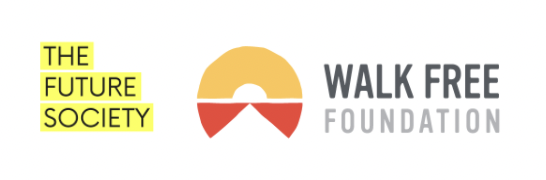

#*Project AIMS (AI against Modern Slavery)*
---




##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://colab.research.google.com/drive/1a1v58GJmtnPX3a1QiqbR46jMMkFIdTJG?usp=sharing).

<h1>Multi-class classification for the MSA Approval Metric</center></h1>
 
<h2> Main goal </h2>
 
<div class="alert alert-block alert-info">
The MSA requires that the statements are discussed and approved by the senior management level. This ensures senior-level accountability, leadership and responsibility for modern slavery and gives it the serious attention it deserves. A statement only belongs to one of three classes 1) Approved by the board, 2) Approval not explicit in the statement, and 3) Approved - not by Board.  This notebook aims to explore and demonstrate using machine learning models for this multi-class classification task.
</div>



<h2> Metric Label Overview </h2>
 
<div class="alert alert-block alert-info">
<b>1. Approval not explicit in statement:</b> Approval by board is not explicit. No mention of any sort of approval in the statement.
</div>
 
<div class="alert alert-block alert-info">
<b>2. Approval not explicit in statement:</b> Approval by the board is explicit in the statement. The statement explicitly mentions that the statement has received approval from the company's board. It must be explicit that it has been "been approved by the board" or "on behalf of the board", NOT that a board member has signed the statement. This is usually found at the end of the statement or first page.
 
<b>Example:</b> This statement was approved by the Boards of Marks and Spencer Group plc, Marks and Spencer plc and Marks Spencer Simply Food Limited.
</div>
 
<div class="alert alert-block alert-info">
<b>3. Approved - not by Board:</b> Approval is explicit in the statement, but by a person/entity other than the board. The statement mentions that it was approved, but the entity is not a representative of the Board or the Board itself.
 
<b>Example:</b> his statement has been approved by the Chief Operating Officer of ESLJ.
</div>



### 🗄️ You can access the data used in this notebook [here](https://drive.google.com/file/d/1xThQSWn501Jlxfay-c7u-EjTu-3R1FAg/view?usp=sharing).We recommend you re-run this research with an updated version of this data which can be downloaded following these [instructions](https://github.com/the-future-society/Project-AIMS-AI-against-Modern-Slavery/tree/main/%F0%9F%97%84%EF%B8%8F%20Data%20and%20text%20extraction/WikiRate).

In [ ]:
# First define data path
DATA_PATH = 'approval.csv'

<h2> Data Overview and Preprocessing </h2>
 
<div class="alert alert-block alert-info">
  
The original data (in the csv file) has 11 columns that are referred to as features. These features describe the properties of each statement, including the origin of a statement, the URL of its answering page, and other identifiers. However, only three features are considered in this work:
<ul>
<li>the content of a statement extracted from its corresponding PDF file, </li>
<li>the comments from annotators that describe the reason for labelling a statement, and </li>
<li>the label of a statement, which is the response variable.</li>
</ul>
 
</div>



In [ ]:
import pandas as pd
df = pd.read_csv(DATA_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936 entries, 0 to 1935
Data columns (total 11 columns):
Answer Page                1936 non-null object
Metric                     1936 non-null object
Company                    1936 non-null object
Year                       1936 non-null int64
Value                      1936 non-null object
Source Page                1932 non-null object
Original Source            1311 non-null object
Source Count               1936 non-null int64
Comments                   1328 non-null object
TEXT                       1319 non-null object
Wikirate Approval Value    0 non-null float64
dtypes: float64(1), int64(2), object(8)
memory usage: 166.5+ KB


<div class="alert alert-block alert-info">
   The label feature (the <b>Value</b> column) in the original data has four distinct values, where 3 of them are actual classes of approval metrics: 1) Approved by the board, 2) Approval not explicit in the statement, and 3) Approved - not by Board. The extra value is named ‘Unknown’. This category records statements that cannot be found in their origins and hence are labelled as ‘Unknown’ by WikiRate. All statements with ‘Unknown’ will not be considered and should be removed.
</div>



In [ ]:
# the label column needs to be cleaned by removing digits and line spliter '\n'
def clean_label(text):
    result = ''.join([i for i in text if not i.isdigit()])
    result = result.strip()
    result = result.split("\n")[0]
    return result

df["Value"]= df["Value"].apply(clean_label)
df.Value.unique()

array(['Approval not explicit in statement', 'Approved by Board',
       'Approved - not by Board', 'Unknown'], dtype=object)

In [ ]:
print("shape before removing the Unknowns : ", df.shape)
df = df.loc[df["Value"] != "Unknown"]
print ("shape after removing the Unknowns : ", df.shape)

shape before removing the Unknowns :  (1936, 11)
shape after removing the Unknowns :  (1680, 11)


<div class="alert alert-block alert-info">
 
The content of a statement extracted from its PDF is the actual textual data. However, we found that some statements have no texts due to errors introduced in the extraction process. These errors should be further investigated. In this work, we simply dismiss all statements with no texts. There are <b>1,139</b> valid statements after removing all statements with ‘Unknown’ or having no texts.
 
All valid statements are further processed by removing tokens that are typographical symbols (e.g. bullets) or page notations (e.g. page 6). The average number of tokens is 920, and the maximum number of tokens is 1,995 after preprocessing.
  
</div>



In [ ]:
df = df.loc[~df["TEXT"].isna()]
print("shape after removing the statements having no texts : ", df.shape)

shape after removing the statements having no texts :  (1139, 11)


<h2> Key Challenges </h2>
 
<div class="alert alert-block alert-info">
   We identified two key challenges: <b>imbalance class distributions</b> and <b>overly lengthy texts of statements.</b>
 
<b>Imbalance class distributions: </b>The minority class (Approved-not by the Board) accounted for less than 7% out of the total statements, whereas the majority statements fall into ‘Approved by the Board’ class, as the following table shows. Such imbalance class distribution will introduce significant bias in machine learning models as they will not efficiently learn to classify the minor class due to a lack of training examples compared to the primary types.
</div>
 
|Class|Samples|%|
|------|------|------|
|Approved by the Board     |601    |52,77%     |
|Approval not explicit in the statement     |462     |40,56%     |
|Approved - not by Board|76|6.67%|



In [ ]:
df["Value"].value_counts()

Approved by Board                     601
Approval not explicit in statement    462
Approved - not by Board                76
Name: Value, dtype: int64

<div class="alert alert-block alert-info">
<b>Overly lengthy texts of statements: </b>The average number of tokens is 875, which is too long to feed machine learning models such as neural networks. This is because a statement is represented as the concatenation of its word representations. Assume that word vectors have the size of 100. The dimension of a statement can easily grow to 87,5000. However, the total number of statements is 1,139. Machine learning models such as neural networks will be very hard to converge on such a small dataset.



In [ ]:
import nltk
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
# average length
tokens = []
for text in df["TEXT"].values:
    tokens += nltk.word_tokenize(text)
print('average length of a document', len(tokens)/df.shape[0])

average length of a document 875.4758560140474


***


<div class="alert alert-block alert-danger">
<h1>Organisation of the rest of this notebook</h1> 
    
The rest of this notebook is organised as follows:
    
<ul>
<li>Baseline performance -- predicting using comments</li>
<li>Applying the transformer model using texts of documents</li>
<li>Dimension reduction with SVM and Perceptron</li>
</ul> 
    
</div>


***

<h2>Baseline -- Predicting using Comments</h2>
 
<div class="alert alert-block alert-info">
The values of target features are predicted based on Comments on the Text extracts. For this approach, the blank Comments should be replaced by their corresponding text values. Text statements show an average of 920 tokens and 1995 tokens as a maximum. Because statements are long documents to feed downstream tasks such as training neural network-based models, usually, it is required to condensate this document to represent them to enable predictive capabilities with the problem at hand. In this approach, it is believed that the approval for the MSA report should be presented in the first few sentences or the last few sentences of the report. Therefore, the first four sentences and the last four sentences are combined and considered to predict the target variable.
As the target MSA Approval status feature contains three different values (“Approved by the board”, “Approved – not by the board”, “Approval not explicit in the statement”), this task becomes a multi-class classification problem. The Transformer is a novel architecture, and it is used to solve the long sequence classification task by efficiently handling the dependencies in the tokens. Different transformer modelling techniques are explored in this work, and other transformer models are used to check their performance on the data.
 
</div>



In [ ]:
df_comments = df.loc[df["Comments"].notna()]
print(df_comments['Value'].value_counts())
print(df_comments.shape)

Approved by Board                     532
Approval not explicit in statement    240
Approved - not by Board                69
Name: Value, dtype: int64
(841, 11)


In [ ]:
#!pip install transformers
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


/Users/rui/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


In [ ]:
# print & check
print('Original: ', df_comments["Comments"][0][:15])
print('Tokenized: ', tokenizer.tokenize(df_comments["Comments"][0][:15]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize\
                                                     (df_comments["Comments"][0][:15])))

Original:  It merely menti
Tokenized:  ['it', 'merely', 'men', '##ti']
Token IDs:  [2009, 6414, 2273, 3775]


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
sentences = df_comments["Comments"]
input_ids = []
lengths = []

for sent in sentences:
    encoded_sent = tokenizer.encode(sent, add_special_tokens = True,)
    input_ids.append(encoded_sent)
    lengths.append(len(encoded_sent))

print('{:>10,} comments'.format(len(input_ids)))

       841 comments


Text(0, 0.5, '# of Comments')

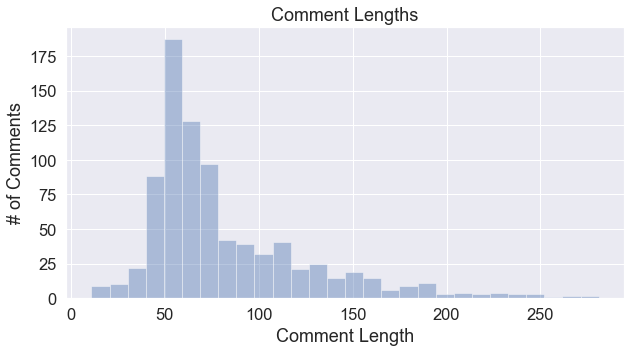

In [ ]:
# plot comment's lengths
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)
sns.distplot(lengths, kde=False, rug=False)

plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('# of Comments')

In [ ]:
# create 'y' dependent variable based on labels
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_comments['y'] = labelencoder.fit_transform(df_comments['Value'])
df_comments[['y', 'Value']][:10]

/Users/rui/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,y,Value
0,0,Approval not explicit in statement
2,0,Approval not explicit in statement
3,0,Approval not explicit in statement
4,2,Approved by Board
6,2,Approved by Board
13,2,Approved by Board
14,2,Approved by Board
17,1,Approved - not by Board
19,0,Approval not explicit in statement
20,2,Approved by Board


In [ ]:
df_comments.reset_index(inplace=True, drop=True)

In [ ]:
y = df_comments['y']
X = df_comments['Comments']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

df_xtrain = x_train.to_frame()
df_ytrain = y_train.to_frame()

df_xtest = x_test.to_frame()
df_ytest = y_test.to_frame()

print(df_ytrain['y'].value_counts())
print(df_ytest['y'].value_counts())

2    372
0    168
1     48
Name: y, dtype: int64
2    160
0     72
1     21
Name: y, dtype: int64


In [ ]:
df_train = pd.concat([df_xtrain, df_ytrain], axis=1)
df_test = pd.concat([df_xtest, df_ytest], axis=1)

In [ ]:
df_train.head()

,Comments,y
544,It has been approved and signed on 17 June 201...,1
773,CVC has been a signatory of the Principles for...,0
121,"Bullet point 3 states: ""It was approved by the...",2
373,"""It was approved by our board of directors on ...",2
779,This statement was approved by the Board of Di...,2


In [ ]:
! pip install tensorboardX

     |████████████████████████████████| 133kB 1.4MB/s eta 0:00:01


In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging
import torch

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

model_args = ClassificationArgs(num_train_epochs=2, overwrite_output_dir=True,)
model = ClassificationModel(
    "roberta", "saibo/legal-roberta-base", 
    num_labels=3,
    args=model_args, 
    use_cuda=False
)

INFO:filelock:Lock 140325821176464 acquired on /Users/rui/.cache/huggingface/transformers/2996bed1c4a43cb6505bf0478646a31b5cf5e1c0e0b485f9974d08f53a5834c7.ee5d081e1ccb5dc7bfcbc3899a74ecc6f9f689ebc1c56b124c4aa147ae77fa5d.lock


Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

INFO:filelock:Lock 140325821176464 released on /Users/rui/.cache/huggingface/transformers/2996bed1c4a43cb6505bf0478646a31b5cf5e1c0e0b485f9974d08f53a5834c7.ee5d081e1ccb5dc7bfcbc3899a74ecc6f9f689ebc1c56b124c4aa147ae77fa5d.lock
Some weights of the model checkpoint at saibo/legal-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenc

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

INFO:filelock:Lock 140325860642960 released on /Users/rui/.cache/huggingface/transformers/80312dcd3c8241bc24b3f968c5966cb7feffc01d170b3f9c3fad8ee0d3bf531e.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05.lock
INFO:filelock:Lock 140325874317136 acquired on /Users/rui/.cache/huggingface/transformers/a66fdc48ac3645ba2785eb593086937584be077431a01b3da3f9db543fb07687.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

INFO:filelock:Lock 140325874317136 released on /Users/rui/.cache/huggingface/transformers/a66fdc48ac3645ba2785eb593086937584be077431a01b3da3f9db543fb07687.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
INFO:filelock:Lock 140325872707600 acquired on /Users/rui/.cache/huggingface/transformers/d1460435294561c579bb618f849e1b3b390f5ebf9751a8e7341ff522d797a643.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0.lock


Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

INFO:filelock:Lock 140325872707600 released on /Users/rui/.cache/huggingface/transformers/d1460435294561c579bb618f849e1b3b390f5ebf9751a8e7341ff522d797a643.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0.lock
INFO:filelock:Lock 140325848505232 acquired on /Users/rui/.cache/huggingface/transformers/97ffa624d9f9f63c729ad3c271df7cee7161bd25a4486057c95163d617cedee9.493977caa7876a6c4298ac82917f8e9e3953149f050a44bc966d0e5fca75da9e.lock


Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

INFO:filelock:Lock 140325848505232 released on /Users/rui/.cache/huggingface/transformers/97ffa624d9f9f63c729ad3c271df7cee7161bd25a4486057c95163d617cedee9.493977caa7876a6c4298ac82917f8e9e3953149f050a44bc966d0e5fca75da9e.lock


In [ ]:
model.train_model(df_train)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/588 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/74 [00:00<?, ?it/s]

/Users/rui/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running Epoch 1 of 2:   0%|          | 0/74 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


(148, 0.5136192047062356)

<div class="alert alert-block alert-info">
Apply to hold out test set
</div> 

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = model.eval_model(df_test,f1=f1_multiclass, 
                                                            acc=accuracy_score)

/Users/rui/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/253 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.6776504426156719, 'f1': 0.841897233201581, 'acc': 0.841897233201581, 'eval_loss': 0.45573000522563234}


## Results


In [ ]:
from sklearn import metrics

predictions = np.arange(model_outputs.shape[0])
predictions_ = np.argmax(model_outputs,axis=1)

# Print the confusion matrix
print(metrics.confusion_matrix(df_test['y'].values, predictions_))

# Print the precision and recall, among other metrics
print(metrics.classification_report(df_test['y'].values, predictions_, digits=3))

[[ 64   0   8]
 [  3   0  18]
 [ 11   0 149]]
              precision    recall  f1-score   support

           0      0.821     0.889     0.853        72
           1      0.000     0.000     0.000        21
           2      0.851     0.931     0.890       160

    accuracy                          0.842       253
   macro avg      0.557     0.607     0.581       253
weighted avg      0.772     0.842     0.805       253



/Users/rui/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h2>  Machine Learning Approaches</h2>

<h3> Model 1: Applying Transformers Using All Texts </h3>
 
The Transformer is a novel architecture that aims to solve sequence classification tasks while handling dependencies with ease. It relies entirely on self-attention to compute representations of its input and output. Self-attention involves relating different positions of a single sequence to compute a representation of the same sequence. The LEGAL-ROBERTA model was used to achieve the task, a domain-specific language representation model pre-trained and fine-tuned on large-scale legal corpora.
</div> 
 
<div class="alert alert-block alert-info">
Model 1: The first transformer model used is Fin-BERT, a domain-specific language representation model fine-tuned on large-scale finance corpora. To reduce the size of documents, only the first and last sentences as used for training and testing.
</div>
 



In [ ]:
import re
def choose_sentences(doc):
    sentences = []
    sentences = re.split(r'[.!?\n]+', doc)
    if len(sentences) >= 20:
        first4 = sentences[:10] 
        last4 = sentences[-10:] 
        first4.extend(last4) 
        return ' '.join(first4)
    else:
        return doc

In [ ]:
df['X'] = df['TEXT'].apply(choose_sentences)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['y'] = labelencoder.fit_transform(df['Value'])
df[['y', 'Value']][:10]

,y,Value
0,0,Approval not explicit in statement
2,0,Approval not explicit in statement
3,0,Approval not explicit in statement
4,2,Approved by Board
6,2,Approved by Board
13,2,Approved by Board
14,2,Approved by Board
17,1,Approved - not by Board
19,0,Approval not explicit in statement
20,2,Approved by Board


In [ ]:
# Import Tokenizer
from transformers import BertForSequenceClassification, BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')

In [ ]:
texts = df.X.values
labels = df.Value.values
token_len = []
for text in texts:
    tokens = tokenizer.encode_plus(text, add_special_tokens=False,
                               return_tensors='pt')
    token_len.append(len(tokens['input_ids'][0]))

print(max(token_len))
print(min(token_len))

284
22


In [ ]:
# importing lemmatizer for preprocessing of text
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
lemma = WordNetLemmatizer()

In [ ]:
def rgx_remove_page_notation(string):
    """
    Remove references to page numbers. The following pattern is intended to capture the following examples both lower and uppercase, with or without brackets:
    page 6, pg.6, p. 6, p.6, p6
    This function should come before the noise removal as the latter may occasionally interfere the page notation in complex cases.
    """
    pattern = "\(?[pP](age|g)?\.?\s?\d\)?"
    return re.sub(pattern, '', string)

def rgx_remove_noise_from_comments(string):
    """
    Since comments are often in the format:
    `{Comment contents} Name[{URL}].... {Datetime} UTC` we're going to strip the comments of the name, URL and datetime contents.
    Also remove line breaks.
    """
    pattern = '[\w\s]+\[(.*?)UTC'
    string_proc = re.sub(pattern, '', string)
    string_proc = string_proc.replace('\n', '')
    return string_proc
def clean_text(text):
    #text = rgx_remove_page_notation(text)
    #text = rgx_remove_noise_from_comments(text)
    text = re.sub(r'http\S', '', text)
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = str(text).lower()
    text = word_tokenize(text)
    text = [lemma.lemmatize(word = w, pos = 'v') for w in text]
    text = [i for i in text if len(i)>2]
    text = ''.join(text)
    return text

In [ ]:
from sklearn.model_selection import train_test_split

labels = df['y']
X1 = df['X']

X_train, X_test, Y_train, Y_test = train_test_split(X1, labels, test_size = 0.4, random_state = 99, stratify = labels)
print(len(X_test))
print(len(Y_test))

X_val = X_test[0:309]
Y_val = Y_test[0:309]
X_test1 = X_test[309:]
Y_test1 = Y_test[309:]

print(len(X_val))
print(len(Y_val))
print(len(X_test1))
print(len(Y_test1))

df_xtrain = X_train.to_frame() 
df_ytrain = Y_train.to_frame()

df_xval = X_val.to_frame() 
df_yval = Y_val.to_frame()

df_xtest = X_test1.to_frame()
df_ytest = Y_test1.to_frame()


df_train = pd.concat([df_xtrain, df_ytrain], axis = 1)
df_val = pd.concat([df_xval, df_yval], axis = 1)
df_test = pd.concat([df_xtest, df_ytest], axis = 1)
print("training dataset shape: ", df_train.shape)
print("label distribution in training data:\n", df_train['y'].value_counts())
print("test dataset shape: ", df_test.shape)
print("label distribution in test data:\n", df_test['y'].value_counts())
print("val dataset shape: ", df_val.shape)
print("label distribution in val data:\n", df_val['y'].value_counts())

456
456
309
309
147
147
training dataset shape:  (683, 2)
label distribution in training data:
 2    360
0    277
1     46
Name: y, dtype: int64
test dataset shape:  (147, 2)
label distribution in test data:
 2    79
0    61
1     7
Name: y, dtype: int64
val dataset shape:  (309, 2)
label distribution in val data:
 2    162
0    124
1     23
Name: y, dtype: int64


In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn import metrics

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

labels_df_test_np = df_val['y'].to_numpy()


In [ ]:
df_train.head()

,X,y
1303,PEMBROKE PEMBROKE MANAGING AGENCY Statement on...,2
674,CALIFORNIA TRANSPARENCY IN SUPPLY CHAINS ACT E...,0
1847,Neuberger Berman Europe Limited 2019 Slavery a...,2
1028,6/18/2019 Home / Anti-slavery statement Anti-s...,0
875,01494 703 200 in Q MENU Modern Slavery and Hum...,0


In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
## Training the model for 5 epochs and saving result into dataframe
## Dataframe name:  df_results
# 1st cloumn: 0predictedas0 : number of class 0 records which are correctly predicted as 0
# 2nd cloumn: 0predictedas2 : number of class 0 records which are wrongly predicted as 2
# 3rd cloumn: 2predictedas0 : number of class 2 records which are wrongly predicted as 0
# 4th cloumn: 2predictedas2 : number of class 2 records which are correctly predicted as 2
# 5th column: precision0 : Precision score of class 0 at that epoch
# 6th column: precision2 : Precision score of class 2 at that epoch
# 7th column: recall0 : Recall score of class 0 at that epoch
# 8th column: recall2 : Recall score of class 2 at that epoch
# 9th column: f1-0 : F1 score of class 0 at that epoch
# 10th column: f1-2 : F1 score of class 2 at that epoch
def training(pretrained_model, df_train):
    model_args = ClassificationArgs(num_train_epochs=1, 
                                    overwrite_output_dir=True, learning_rate= 4e-05)

    model_1 = ClassificationModel(
        "bert", pretrained_model, 
        num_labels=3,
        args=model_args,
        use_cuda=False,
    )
    df_results = pd.DataFrame(columns=['0predictedas0', '0predictedas2', '2predictedas0', 
                                       '2predictedas2', 'precision0', 'precision2', 
                                       'recall0', 'recall2', 'f1-0', 'f1-2'])
    for i in range(3):
        model_1.train_model(df_train)
        result, model_outputs, wrong_predictions = model_1.eval_model(df_val,f1=f1_multiclass,
                                                                      acc=accuracy_score)
        predictions = np.arange(model_outputs.shape[0])
        predictions_ = np.argmax(model_outputs,axis=1)
        print(metrics.confusion_matrix(labels_df_test_np, predictions_))
        print(metrics.classification_report(labels_df_test_np, predictions_, digits=3))
        conf_metric = metrics.confusion_matrix(labels_df_test_np, predictions_)
        zpredictedasz = conf_metric[0][0]
        zpredictedast = conf_metric[0][2]
        tpredictedasz = conf_metric[2][0]
        tpredictedast = conf_metric[2][2]
        p0 = precision_score(labels_df_test_np, predictions_, labels= [0], average= 'micro')
        p2 = precision_score(labels_df_test_np, predictions_, labels= [2], average= 'micro')
        r0 = recall_score(labels_df_test_np, predictions_, labels= [0], average= 'micro')
        r2 = recall_score(labels_df_test_np, predictions_, labels= [2], average= 'micro')
        f0 = f1_score(labels_df_test_np, predictions_, labels= [0], average= 'micro')
        f2 = f1_score(labels_df_test_np, predictions_, labels= [2], average= 'micro')
        df_results.loc[len(df_results)] = [zpredictedasz, zpredictedast, tpredictedasz, 
                                           tpredictedast, p0, p2, r0, r2, f0, f2]

## Results

In [ ]:
training('ProsusAI/finbert', df_train)
training('ipuneetrathore/bert-base-cased-finetuned-finBERT', df_train)
training('roberta-large-mnli', df_train)

/Users/rui/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
/Users/rui/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/683 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/86 [00:00<?, ?it/s]

/Users/rui/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/Users/rui/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/309 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/39 [00:00<?, ?it/s]

[[  2   0 122]
 [  1   0  22]
 [  4   0 158]]
              precision    recall  f1-score   support

           0      0.286     0.016     0.031       124
           1      0.000     0.000     0.000        23
           2      0.523     0.975     0.681       162

    accuracy                          0.518       309
   macro avg      0.270     0.330     0.237       309
weighted avg      0.389     0.518     0.369       309



/Users/rui/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/683 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/39 [00:00<?, ?it/s]

[[ 53   0  71]
 [  5   0  18]
 [ 54   0 108]]
              precision    recall  f1-score   support

           0      0.473     0.427     0.449       124
           1      0.000     0.000     0.000        23
           2      0.548     0.667     0.602       162

    accuracy                          0.521       309
   macro avg      0.340     0.365     0.350       309
weighted avg      0.477     0.521     0.496       309



  0%|          | 0/683 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/39 [00:00<?, ?it/s]

[[ 51   1  72]
 [  6   0  17]
 [ 47   1 114]]
              precision    recall  f1-score   support

           0      0.490     0.411     0.447       124
           1      0.000     0.000     0.000        23
           2      0.562     0.704     0.625       162

    accuracy                          0.534       309
   macro avg      0.351     0.372     0.357       309
weighted avg      0.491     0.534     0.507       309



Downloading:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

  0%|          | 0/683 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

KeyboardInterrupt: 

# <div class="alert alert-block alert-info">
<h3> Model 2: Support Vector Machine </h3>
 
Support Vector Machine (SVM) is a statistical learning model that aims to map training examples to points in feature space to maximise the width of the gap between the samples of the different classes.
</div> 



In [ ]:
# Transform every statement into a vector on the basis of the occurrence 
# and/or the counting of each n-gram (1 to 5) that occurs in the entire text.
from sklearn.feature_extraction.text import CountVectorizer
documents = []
for index, row in df.iterrows():
    documents.append(row['TEXT'])
    
doc_set = documents
vectorizer = CountVectorizer(ngram_range=(1, 5),stop_words='english', binary=True)
tf = vectorizer.fit_transform(doc_set)
vectorizer.vocabulary_
vectorizer.get_feature_names()
tf.toarray()


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Explore the n-grams related with approval metric
my_vocabulary=['approval', 'approval 2018 msa statement', 'approval accordance section', 
               'approval behalf', 'approval board', 'approval board directors', 
               'approval board management', 'approval brands executive leadership', 
               'approval chief', 'approval director', 'approval executive committee board', 
               'approval management', 'approval statement', 'approval procedure statement', 
               'approval signature', 'approval signed', 
               'approval signature statement approved board', 
               'approval statement approved', 'approval statement behalf board', 
               'approval statement behalf chairman', 'approval statement behalf group chief', 
               'approval statement behalf managing director', 
               'approval statement covers financial year', 'approval statement section 54', 
               'statement approved board', 'approval statement', 'approvals', 
               'approvals board', 'approvals statement approved board', 'approvals statement',
               'approve statement', 'approved adopted board directors', 'approved adopted', 
               'approved agreed board directors', 'approved anti-slavery officer', 
               'approved appropriate executive board', 'approved behalf board directors', 
               'approved behalf members', 'approved behalf', 'approved board', 'approved', 
               'approved company board directors', 'approved corporate governance committee', 
               'approved corporate sustainability committee board', 'approved council', 
               'approved director', 'approved directors', 'approved executive committee', 
               'approved firm board members', 'approved group board directors', 
               'approved group', 'approved management board', 'approved managing board', 
               'approved managing director', 'approved managing partners', 'approved members',
               'approved modern slavery act statement', 
               'approved organisation board directors', 'approved relevant board directors', 
               'approved relevant entities boards', 'approved signed board directors', 
               'approved signed behalf members', 'approved statement']

vectorizer = CountVectorizer(ngram_range=(1, 5))
vectorizer.fit_transform(my_vocabulary)
tf = vectorizer.transform(doc_set)

vectorizer.vocabulary_

{'approval': 20,
 '2018': 0,
 'msa': 196,
 'statement': 225,
 'approval 2018': 21,
 '2018 msa': 1,
 'msa statement': 197,
 'approval 2018 msa': 22,
 '2018 msa statement': 2,
 'approval 2018 msa statement': 23,
 'accordance': 4,
 'section': 210,
 'approval accordance': 24,
 'accordance section': 5,
 'approval accordance section': 25,
 'behalf': 130,
 'approval behalf': 26,
 'board': 139,
 'approval board': 27,
 'directors': 165,
 'board directors': 140,
 'approval board directors': 28,
 'management': 185,
 'board management': 141,
 'approval board management': 29,
 'brands': 144,
 'executive': 168,
 'leadership': 184,
 'approval brands': 30,
 'brands executive': 145,
 'executive leadership': 172,
 'approval brands executive': 31,
 'brands executive leadership': 146,
 'approval brands executive leadership': 32,
 'chief': 148,
 'approval chief': 33,
 'director': 164,
 'approval director': 34,
 'committee': 149,
 'approval executive': 35,
 'executive committee': 170,
 'committee board': 15

In [ ]:
# Get the final document representation a matrix (1139,244)
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

robtf = tf.toarray()
print(robtf.shape)

X_train, X_test, y_train, y_test = model_selection.train_test_split(robtf, 
                df['y'], train_size=0.70, test_size=0.30, random_state=101)

(1139, 244)


In [ ]:
# Train two support vector machine models
rbf = svm.SVC(kernel='rbf', gamma=1e-4, C=0.1).fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (Polynomial Kernel):  58.48
F1 (Polynomial Kernel):  56.16
Accuracy (RBF Kernel):  55.85
F1 (RBF Kernel):  40.03


In [ ]:
# Evaluate support vector machines
from sklearn.metrics import f1_score, accuracy_score
from sklearn import metrics

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

## Results

In [ ]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(y_test, poly_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, poly_pred, digits=3))

# Print the confusion matrix
print(metrics.confusion_matrix(y_test, rbf_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, rbf_pred, digits=3))

[[104   0  17]
 [ 19   1  10]
 [ 95   1  95]]
              precision    recall  f1-score   support

           0      0.477     0.860     0.614       121
           1      0.500     0.033     0.062        30
           2      0.779     0.497     0.607       191

    accuracy                          0.585       342
   macro avg      0.585     0.463     0.428       342
weighted avg      0.648     0.585     0.562       342

[[  0   0 121]
 [  0   0  30]
 [  0   0 191]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       121
           1      0.000     0.000     0.000        30
           2      0.558     1.000     0.717       191

    accuracy                          0.558       342
   macro avg      0.186     0.333     0.239       342
weighted avg      0.312     0.558     0.400       342



/Users/rui/opt/anaconda3/envs/Deeplearning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<div class="alert alert-block alert-info">
<h3> 6.3 Multilayer perceptron </h3>
This method is a class of neural networks. Commonly used to deal with high dimensional feature representation. This method was used to feed documents represented as a long vector of 244 dimensions.
</div>  

In [ ]:
from keras.models import Sequential #Sequential Models
from keras.layers import Dense #Dense Fully Connected Layer Type
from keras.optimizers import SGD #Stochastic Gradient Descent Optimizer

def create_network():
    model = Sequential()
    model.add(Dense(244, input_shape=(244,), activation='relu'))
    model.add(Dense(122, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(3, activation='softmax'))
        
    #stochastic gradient descent
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [ ]:
X = X_train
Y = y_train

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
Y = encoder.fit_transform(Y)

In [ ]:
# Train the neural network
neural_network = create_network()
neural_network.fit(X,Y, epochs=500, batch_size=10)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/500





797/797 [==============================] - 1s 2ms/step - loss: 0.9389 - acc: 0.5169
Epoch 2/500
797/797 [==============================] - 0s 373us/step - loss: 0.8424 - acc: 0.6211
Epoch 3/500
797/797 [==============================] - 0s 429us/step - loss: 0.8029 - acc: 0.6437
Epoch 4/500
797/797 [==============================] - 0s 365us/step - loss: 0.7577 - acc: 0.6888
Epoch 5/500
797/797 [==============================] - 0s 357us/step - loss: 0.7485 - acc: 0.6888
Epoch 6/500
797/797 [==============================] - 0s 368us/step - loss: 0.7056 - acc: 0.7127
Epoch 7/500
797/797 [==============================] - 0s 365us/step - loss: 0.6749 - acc: 0.7302
Epoch 8/500
797/797 [==============================] - 0s 363us/step - loss: 0.6662 - acc: 0.7566
Epoch 9/500
797/797 [==============================] - 0s 366us/step - loss: 0.6500 - acc: 0.7465
Epoch 10/500


797/797 [==============================] - 0s 403us/step - loss: 0.1584 - acc: 0.9523
Epoch 52/500
797/797 [==============================] - 0s 408us/step - loss: 0.1528 - acc: 0.9561
Epoch 53/500
797/797 [==============================] - 0s 360us/step - loss: 0.1616 - acc: 0.9410
Epoch 54/500
797/797 [==============================] - 0s 352us/step - loss: 0.1303 - acc: 0.9636
Epoch 55/500
797/797 [==============================] - 0s 352us/step - loss: 0.1361 - acc: 0.9548
Epoch 56/500
797/797 [==============================] - 0s 338us/step - loss: 0.1502 - acc: 0.9548
Epoch 57/500
797/797 [==============================] - 0s 340us/step - loss: 0.1639 - acc: 0.9548
Epoch 58/500
797/797 [==============================] - 0s 344us/step - loss: 0.1454 - acc: 0.9523
Epoch 59/500
797/797 [==============================] - 0s 359us/step - loss: 0.1379 - acc: 0.9548
Epoch 60/500
797/797 [==============================] - 0s 363us/step - loss: 0.1529 - acc: 0.9360
Epoch 61/500
797/797 [=

797/797 [==============================] - 0s 389us/step - loss: 0.0267 - acc: 0.9925
Epoch 134/500
797/797 [==============================] - 0s 422us/step - loss: 0.0260 - acc: 0.9912
Epoch 135/500
797/797 [==============================] - 0s 414us/step - loss: 0.0347 - acc: 0.9900
Epoch 136/500
797/797 [==============================] - 0s 361us/step - loss: 0.1572 - acc: 0.9473
Epoch 137/500
797/797 [==============================] - 0s 406us/step - loss: 0.0469 - acc: 0.9862
Epoch 138/500
797/797 [==============================] - 0s 388us/step - loss: 0.0662 - acc: 0.9774
Epoch 139/500
797/797 [==============================] - 0s 374us/step - loss: 0.0768 - acc: 0.9787
Epoch 140/500
797/797 [==============================] - 0s 375us/step - loss: 0.1103 - acc: 0.9636
Epoch 141/500
797/797 [==============================] - 0s 356us/step - loss: 0.0626 - acc: 0.9824
Epoch 142/500
797/797 [==============================] - 0s 360us/step - loss: 0.0347 - acc: 0.9900
Epoch 143/500


797/797 [==============================] - 0s 376us/step - loss: 0.0184 - acc: 0.9925
Epoch 216/500
797/797 [==============================] - 0s 397us/step - loss: 0.0177 - acc: 0.9925
Epoch 217/500
797/797 [==============================] - 0s 356us/step - loss: 0.0176 - acc: 0.9925
Epoch 218/500
797/797 [==============================] - 0s 361us/step - loss: 0.0183 - acc: 0.9925
Epoch 219/500
797/797 [==============================] - 0s 467us/step - loss: 0.0177 - acc: 0.9925
Epoch 220/500
797/797 [==============================] - 0s 406us/step - loss: 0.0182 - acc: 0.9912
Epoch 221/500
797/797 [==============================] - 0s 453us/step - loss: 0.0174 - acc: 0.9950
Epoch 222/500
797/797 [==============================] - 0s 366us/step - loss: 0.0183 - acc: 0.9912
Epoch 223/500
797/797 [==============================] - 0s 437us/step - loss: 0.0176 - acc: 0.9900
Epoch 224/500
797/797 [==============================] - 0s 369us/step - loss: 0.0180 - acc: 0.9937
Epoch 225/500


797/797 [==============================] - 0s 361us/step - loss: 0.0159 - acc: 0.9925
Epoch 298/500
797/797 [==============================] - 0s 410us/step - loss: 0.0152 - acc: 0.9937
Epoch 299/500
797/797 [==============================] - 0s 366us/step - loss: 0.0157 - acc: 0.9925
Epoch 300/500
797/797 [==============================] - 0s 353us/step - loss: 0.0156 - acc: 0.9937
Epoch 301/500
797/797 [==============================] - 0s 359us/step - loss: 0.0163 - acc: 0.9937
Epoch 302/500
797/797 [==============================] - 0s 357us/step - loss: 0.0154 - acc: 0.9925
Epoch 303/500
797/797 [==============================] - 0s 365us/step - loss: 0.0153 - acc: 0.9925
Epoch 304/500
797/797 [==============================] - 0s 358us/step - loss: 0.0150 - acc: 0.9937
Epoch 305/500
797/797 [==============================] - 0s 356us/step - loss: 0.0144 - acc: 0.9925
Epoch 306/500
797/797 [==============================] - 0s 363us/step - loss: 0.0151 - acc: 0.9937
Epoch 307/500


797/797 [==============================] - 0s 357us/step - loss: 0.0152 - acc: 0.9912
Epoch 380/500
797/797 [==============================] - 0s 359us/step - loss: 0.0149 - acc: 0.9912
Epoch 381/500
797/797 [==============================] - 0s 355us/step - loss: 0.0150 - acc: 0.9900
Epoch 382/500
797/797 [==============================] - 0s 358us/step - loss: 0.0163 - acc: 0.9912
Epoch 383/500
797/797 [==============================] - 0s 355us/step - loss: 0.0159 - acc: 0.9937
Epoch 384/500
797/797 [==============================] - 0s 350us/step - loss: 0.0155 - acc: 0.9912
Epoch 385/500
797/797 [==============================] - 0s 338us/step - loss: 0.0150 - acc: 0.9937
Epoch 386/500
797/797 [==============================] - 0s 359us/step - loss: 0.0147 - acc: 0.9912
Epoch 387/500
797/797 [==============================] - 0s 366us/step - loss: 0.0144 - acc: 0.9937
Epoch 388/500
797/797 [==============================] - 0s 348us/step - loss: 0.0149 - acc: 0.9937
Epoch 389/500


797/797 [==============================] - 0s 349us/step - loss: 0.0150 - acc: 0.9912
Epoch 462/500
797/797 [==============================] - 0s 414us/step - loss: 0.0147 - acc: 0.9925
Epoch 463/500
797/797 [==============================] - 0s 350us/step - loss: 0.0143 - acc: 0.9937
Epoch 464/500
797/797 [==============================] - 0s 351us/step - loss: 0.0143 - acc: 0.9925
Epoch 465/500
797/797 [==============================] - 0s 359us/step - loss: 0.0137 - acc: 0.9937
Epoch 466/500
797/797 [==============================] - 0s 358us/step - loss: 0.0144 - acc: 0.9937
Epoch 467/500
797/797 [==============================] - 0s 360us/step - loss: 0.0142 - acc: 0.9912
Epoch 468/500
797/797 [==============================] - 0s 374us/step - loss: 0.0144 - acc: 0.9925
Epoch 469/500
797/797 [==============================] - 0s 467us/step - loss: 0.0141 - acc: 0.9937
Epoch 470/500
797/797 [==============================] - 0s 368us/step - loss: 0.0140 - acc: 0.9937
Epoch 471/500


In [ ]:
# Evaluate Multilayer perceptron performance
y_hat = neural_network.predict(X_test)

import numpy as np
predictions = np.arange(y_hat.shape[0])
predictions_ = np.argmax(y_hat,axis=1)

## Results


In [ ]:
# Print the confusion matrix
print(metrics.confusion_matrix(y_test, predictions_))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, predictions_, digits=3))

[[ 88   2  31]
 [ 10   9  11]
 [ 27  12 152]]
              precision    recall  f1-score   support

           0      0.704     0.727     0.715       121
           1      0.391     0.300     0.340        30
           2      0.784     0.796     0.790       191

    accuracy                          0.728       342
   macro avg      0.626     0.608     0.615       342
weighted avg      0.721     0.728     0.724       342

